In [2]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
num_bidders = 4

def gen_data(values):
    nobs = 1000
    
    #parameters
    
    
    min_bids =num_bidders
    max_bids =num_bidders
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs

mu = 10
sigma = 3
values_distr =stats.norm(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == num_bidders].mean())

(1000,)
10.874411380832628


In [4]:
scipy.special.factorial([4,3])

array([24.,  6.])

In [5]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.norm, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)
    
mu = 10
sigma = 3
np.random.seed()
yn,xn,nobs = gen_data(stats.norm(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -2019.6
Model:                        Auction   AIC:                             4041.
Method:            Maximum Likelihood   BIC:                             4046.
Date:                Mon, 23 Nov 2020                                         
Time:                        13:50:41                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1224      0.060    168.035      0.000      10.004      10.240
par0           3.0359      0.069     44.275      0.000       2.901       3.170
==============================================================================
"""

In [6]:
mu = 10
sigma = 3
np.random.seed()
yn,xn,nobs = gen_data(stats.norm(loc=mu, scale=sigma))

#fit normal values
model1 = Auction(yn,xn)
model_fit1 = model1.fit(start_params=[mu,sigma],disp=False)

#fit logistic values
model2 = Auction(yn,xn,values_distr=stats.logistic)
model_fit2 = model2.fit(start_params=[mu,sigma],disp=False)



print(model_fit2.summary())
print(model_fit1.summary())
print( (model1.loglikeobs(model_fit1.params) - model2.loglikeobs(model_fit2.params) ).mean() )
print( (model1.loglikeobs(model_fit1.params) - model2.loglikeobs(model_fit2.params) ).var() )

                               Auction Results                                
Dep. Variable:                      y   Log-Likelihood:                -1993.4
Model:                        Auction   AIC:                             3989.
Method:            Maximum Likelihood   BIC:                             3994.
Date:                Mon, 23 Nov 2020                                         
Time:                        13:50:41                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0953      0.058    175.170      0.000       9.982      10.208
par0           1.7601      0.043     41.133      0.0

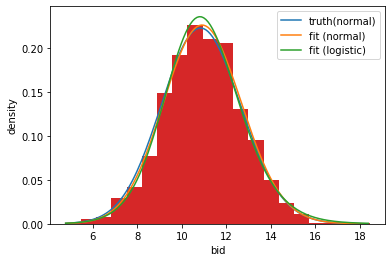

In [7]:
#create plot for true
support_y = np.arange(yn.min(),yn.max(),.1)
support_x = num_bidders*np.ones(len(support_y))
true_model = Auction(support_y,support_x)
true_model_y = np.exp(true_model.loglikeobs([mu,sigma]))
plt.plot(support_y, true_model_y ,label="truth(normal)")

#create plot for normal
fit_normal_y = np.exp(true_model.loglikeobs(model_fit1.params))
plt.plot(support_y, fit_normal_y ,label="fit (normal)")

#create plot for logistic
logistic_model = Auction(support_y,support_x,values_distr=stats.logistic)
fit_logistic_y = np.exp(logistic_model.loglikeobs(model_fit2.params))
plt.plot(support_y, fit_logistic_y ,label="fit (logistic)")

plt.legend()
plt.hist(yn,bins=20,density=True)

plt.ylabel("density")
plt.xlabel("bid")
#plt.ylim((0.,100.))
plt.savefig('../figs/auction_plot1.png')
#plt.xlim((-.25,0.75))
#plt.savefig('figs/nonnested_zoom')
plt.show()

plt.show()
